# Analyse de données de WaPOR

Ce notebook contient des exemples de codes pour analyser les données de WaPOR, incluant:
- [1. Calculer la valeur moyenne d’une région d’intérêt](#1.-Calculer-la-valeur-Moyenne-d’une-zone-d’intérêt)
- [2. Travailler avec des séries chronologiques (librairie pandas)](#2.-Travailler-avec-des-séries-chronologiques-(librairie-pandas))
- [3. Calcul de raster](#3.-Calcul-de-raster)
- [4. Analyse de l’occupation des terres](#4.-Analyse-de-l’occupation-des-terres)

Après les exemples, il y aura des exercices de codage pour vous permettre de pratiquer.

### Importer des librairies et des fonctions
Pour cet exercice, nous pouvons nous servir des fonctions définies par l’utilisateur que nous avons élaborées dans l’exercice précédent pour lire et écrire des données raster.

In [1]:
import numpy as np
import gdal
import osr
import os
import matplotlib.pyplot as plt
import pandas as pd
import glob
import ogr
import datetime

def GetGeoInfo(fh, subdataset = 0):
    """
    Extraire la métadonnée à partir d’un fichier geotiff, HDF4 ou netCDF. 
    
    Paramètres 
    ----------
    fh : str
        Gestion-de-fichier du fichier à scruter 
    subdataset : int, optional
        Couche à utiliser en cas de format HDF4 ou netCDF, est 0 par défaut. 
        
    Retours 
    -------
    driver : str
        Driver de  fh. 
    NDV : float
        Valeur sans-donnée de fh. 
    xsize : int
        Nombre de pixels dans la direction x. 
    ysize : int
         Nombre de pixels dans la direction y.
    GeoT : list
        Liste avec les valeurs de géotransformation. 
    Projection : str
        Projection de fh. 
    """
    SourceDS = gdal.Open(fh, gdal.GA_ReadOnly)
    Type = SourceDS.GetDriver().ShortName
    if Type == 'HDF4' or Type == 'netCDF':
        SourceDS = gdal.Open(SourceDS.GetSubDatasets()[subdataset][0])
    NDV = SourceDS.GetRasterBand(1).GetNoDataValue()
    xsize = SourceDS.RasterXSize
    ysize = SourceDS.RasterYSize
    GeoT = SourceDS.GetGeoTransform()
    Projection = osr.SpatialReference()
    Projection.ImportFromWkt(SourceDS.GetProjectionRef())
    driver = gdal.GetDriverByName(Type)
    return driver, NDV, xsize, ysize, GeoT, Projection

def OpenAsArray(fh, bandnumber = 1, dtype = 'float32', nan_values = False):
    """
    Ouvrir une carte en tant que Matrice de numpy 
    
    Paramètres
    ----------
    fh: str
        Gestion de fichier pour cartographier, pour ouvrir 
    bandnumber : int, optional 
        Bande ou couche à ouvrir en tant que Matrice, est 1 par défaut.
    dtype : str, optional
        Type de données de la matrice de sortie, est 'float32' par défaut.
    nan_values : boolean, optional
        Convertir les valeurs sans-données en valeurs np.nan, Remarquer que 
        dtype doit être décimal si float est True. Est False par défaut. 
        
    Retours 
    -------
    Array : ndarray
        Array with the pixel values.
    """
    datatypes = {"uint8": np.uint8, "int8": np.int8, "uint16": np.uint16,
                 "int16":  np.int16, "Int16":  np.int16, "uint32": np.uint32,
                 "int32": np.int32, "float32": np.float32, "float64": np.float64, 
                 "complex64": np.complex64, "complex128": np.complex128,
                "Int32": np.int32, "Float32": np.float32, "Float64": np.float64, 
                 "Complex64": np.complex64, "Complex128": np.complex128,}
    DataSet = gdal.Open(fh, gdal.GA_ReadOnly)
    Type = DataSet.GetDriver().ShortName
    if Type == 'HDF4':
        Subdataset = gdal.Open(DataSet.GetSubDatasets()[bandnumber][0])
        NDV = int(Subdataset.GetMetadata()['_FillValue'])
    else:
        Subdataset = DataSet.GetRasterBand(bandnumber)
        NDV = Subdataset.GetNoDataValue()
    Array = Subdataset.ReadAsArray().astype(datatypes[dtype])
    if nan_values:
        Array[Array == NDV] = np.nan
    return Array

def CreateGeoTiff(fh, Array, driver, NDV, xsize, ysize, GeoT, Projection, explicit = True, compress = None):
    """
    Créer un geotiff à partir de la matrice de numpy.
    
    Paramètres
    ----------
    fh : str
        Gestion de fichiers pour la sortie. 
    Array: ndarray
        Array à convertir en geotiff. 
    driver : str
        Driver de fh. 
    NDV : float
        Valeur sans-donnée de la fh. 
    xsize : int
        Nombre de pixels dans la direction x. 
    ysize : int
        Nombre de pixels dans la direction y.
    GeoT : list
        Liste avec les valeurs de géotransformation. 
    Projection : str
        Projection de fh.   
    """
    datatypes = {"uint8": 1, "int8": 1, "uint16": 2, "int16": 3, "Int16": 3, "uint32": 4,
    "int32": 5, "float32": 6, "float64": 7, "complex64": 10, "complex128": 11,
    "Int32": 5, "Float32": 6, "Float64": 7, "Complex64": 10, "Complex128": 11,}
    if compress != None:
        DataSet = driver.Create(fh,xsize,ysize,1,datatypes[Array.dtype.name], ['COMPRESS={0}'.format(compress)])
    else:
        DataSet = driver.Create(fh,xsize,ysize,1,datatypes[Array.dtype.name])
    if NDV is None:
        NDV = -9999
    if explicit:
        Array[np.isnan(Array)] = NDV
    DataSet.GetRasterBand(1).SetNoDataValue(NDV)
    DataSet.SetGeoTransform(GeoT)
    DataSet.SetProjection(Projection.ExportToWkt())
    DataSet.GetRasterBand(1).WriteArray(Array)
    DataSet = None
    if "nt" not in Array.dtype.name:
        Array[Array == NDV] = np.nan


def MatchProjResNDV(source_file, target_fhs, output_dir, resample = 'near', 
                    dtype = 'float32', scale = None, ndv_to_zero = False):
    """
    Fait correspondre (ajuster) la projection, résolution et 
    valeur sans donnée d’une liste de fichiers cibles avec celle 
    d’un fichier source et enregistre les nouvelles cartes dans 
    output_dir (dossier de sortie)
    
    Paramètres
    ----------
    source_file : str 
        Fichier dont la projection, résolution et ndv seront reproduites. 
    target_fhs : list 
        Les fichiers à reprojeter. 
    output_dir : str 
        Dossier de stockage des sorties. 
    resample: str, optional 
        Méthode de redimensionnement à utiliser, est 'near' (plus proche voisin) par défaut. 
    dtype : str, optionnel
        Type de données de sortie, est 'float32' par défaut. 
    scale : int, optionnel 
        Multiplie toutes les cartes par cette valeur, est None (aucun) par défaut. 

    Retours
    -------
    output_files : ndarray 
        Gestions de fichiers des fichiers créés.
    """
    dst_info=gdal.Info(gdal.Open(source_file),format='json')
    output_files = np.array([])
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for target_file in target_fhs:
        folder, fn = os.path.split(target_file)
        src_info=gdal.Info(gdal.Open(target_file),format='json')
        output_file = os.path.join(output_dir, fn)
        gdal.Warp(output_file,target_file,format='GTiff',
                      srcSRS=src_info['coordinateSystem']['wkt'],
                      dstSRS=dst_info['coordinateSystem']['wkt'],
                      srcNodata=src_info['bands'][0]['noDataValue'],
                      dstNodata=dst_info['bands'][0]['noDataValue'],
                      width=dst_info['size'][0],
                      height=dst_info['size'][1],
                      outputBounds=(dst_info['cornerCoordinates']['lowerLeft'][0],
                                    dst_info['cornerCoordinates']['lowerLeft'][1],
                                    dst_info['cornerCoordinates']['upperRight'][0],
                                    dst_info['cornerCoordinates']['upperRight'][1]),
                      outputBoundsSRS=dst_info['coordinateSystem']['wkt'],
                      resampleAlg=resample)
        output_files = np.append(output_files, output_file)
        if not np.any([scale == 1.0, scale == None, scale == 1]):
            driver, NDV, xsize, ysize, GeoT, Projection = GetGeoInfo(output_file)
            DATA = OpenAsArray(output_file, nan_values = True) * scale
            CreateGeoTiff(output_file, DATA, driver, NDV, xsize, ysize, GeoT, Projection)
        if ndv_to_zero:
            driver, NDV, xsize, ysize, GeoT, Projection = GetGeoInfo(output_file)
            DATA = OpenAsArray(output_file, nan_values = False)
            DATA[DATA == NDV] = 0.0
            CreateGeoTiff(output_file, DATA, driver, NDV, xsize, ysize, GeoT, Projection)
    return output_files

def CliptoShp(input_fhs,output_folder,shp_fh,NDV=-9999):
    """ 
    Découpe un raster suivant les limites d’un shapefile
    
    Paramètres
    ----------
    input_fhs : list 
        Liste des fichiers raster d’entrée
    output_folder : str 
        Chemin du dossier où enregistrer les rasters de sortie
    shp_fh : str 
        Dossier d’enregistrement de sorties. 
    NDV : float or int, optional 
        Valeurs sans-donnée du raster de sortie
    
    Retours
    -------
    output_fhs : list 
        Gestions de fichiers des fichiers créés.
    """
    inDriver = ogr.GetDriverByName("ESRI Shapefile")
    inDataSource = inDriver.Open(shp_fh, 1)
    inLayer = inDataSource.GetLayer()    
    options = gdal.WarpOptions(cutlineDSName = shp_fh,
                               cutlineLayer = inLayer.GetName(),
                               cropToCutline = True, 
                               dstNodata=NDV
                               )
    output_fhs=[]
    for input_fh in input_fhs:
        output_fh=os.path.join(output_folder,os.path.basename(input_fh))
        sourceds = gdal.Warp(output_fh, input_fh, options = options)
        output_fhs.append(output_fh)
    return output_fhs

## 1. Calculer la valeur Moyenne d’une zone d’intérêt
### Exemple
Calculer la pluviométrie moyenne d’une zone d’intérêt (ROI) à partir d’une carte raster (mm/mois). 


*ET_folder* et *P_folder* sont les chemins aux dossiers de l’Evapotranspiration réelle et Interception et Précipitation téléchargés à partir de l’exercice du notebook [3 Télécharger en bloc des données de WaPOR ](3_Bulk_download_WaPOR_data.ipynb). Si les fichiers sont téléchargés avec succès, le nombre de fichiers dans chacun de deux dossiers sera 24.

In [2]:
# Définir les dossiesr de ET et P      
ET_folder=r".\data\WAPOR.v2_monthly_L1_AETI_M"
P_folder=r".\data\WAPOR.v2_monthly_L1_PCP_M"
# Obtenir la liste des fichiers dans un dossier:
P_fhs=sorted(glob.glob(os.path.join(P_folder,'*.tif')))
ET_fhs=sorted(glob.glob(os.path.join(ET_folder,'*.tif')))
print('Nombre de fichier dans {0}: {1}'.format(P_folder,len(P_fhs)))
print('Nombre de fichier dans {0}: {1}'.format(ET_folder,len(ET_fhs)))

Nombre de fichier dans .\data\WAPOR.v2_monthly_L1_PCP_M: 24
Nombre de fichier dans .\data\WAPOR.v2_monthly_L1_AETI_M: 24


Premièrement, vérifier si la carte de précipitation est conditionnée à la même taille que la carte AETI de la ROI.

(111, 128)
(2461, 2851)


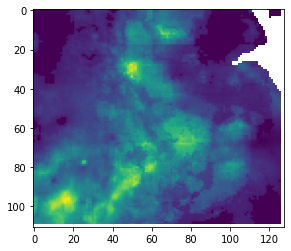

In [3]:
# Obtenir le chemin du premier fichier:
P_fh=P_fhs[0]
ET_fh=ET_fhs[0]
# Ouvrir les fichiers en tant que matrices
P=OpenAsArray(P_fh,nan_values=True)
ET=OpenAsArray(ET_fh,nan_values=True)
#Afficher la forme des matrices 
print(P.shape)
print(ET.shape)

plt.imshow(P)
plt.show()

La taille des matrices de l’ET et P est différente parce que la résolution de niveau 1 de la précipitation est 5km et celle de ET est 250m. Pour conditionner le raster de la précipitation à la même résolution que le raster de l’occupation des terres, utiliser la fonction définie *MatchProjResNDV*

In [4]:
output_folder=r'.\data\WAPOR.v2_monthly_L1_PCP_M_warped'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
P_fhs=MatchProjResNDV(ET_fh, P_fhs, output_folder)

Puis nous allons découper les rasters ET et P de la zone d’intérêt en utilisant le shapefile **".\data\Awash_shapefile.shp"**

In [5]:
shp_fh=r".\data\Awash_shapefile.shp"
ET_folder=r'.\data\WAPOR.v2_monthly_L1_AETI_M_clipped' #Nouveau dossier ET
P_folder=r'.\data\WAPOR.v2_monthly_L1_PCP_M_clipped' # Nouveau dossier P
if not os.path.exists(ET_folder):
    os.makedirs(ET_folder) #Créer nouveau un dossier ET
if not os.path.exists(P_folder):
    os.makedirs(P_folder) #créer un nouveau dossier P
ET_fhs=CliptoShp(ET_fhs,ET_folder,shp_fh) #Découper tous les rasters P suivant le shapefile
P_fhs=CliptoShp(P_fhs,P_folder,shp_fh) #Découper tous les rasters ET suivant le shapefile

Nous pouvons donc obtenir la précipitation moyenne de la zone entière grâce à *numpy.nanmean* qui signifie calculer la moyenne en excluant les pixels avec des valeurs nan.

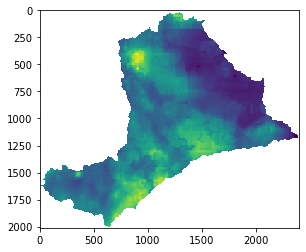

Précipitation moyenne (mm/mois): 25.643678665161133


In [6]:
P=OpenAsArray(P_fhs[0],nan_values=True)
plt.imshow(P)
plt.show()
Average_P=np.nanmean(P)
print('Précipitation moyenne (mm/mois): {0}'.format(Average_P))

Pour obtenir toutes les cartes de précipitation mensuelle (P) et enregistrer la valeur dans une *list* (liste) Python et tracer la précipitation en fonction du temps, nous allons itérer en boucle sur tous rasters mensuels de P et calculer P moyenne et la date. 

Nous pouvons nous servir du nom du fichier pour obtenir l’index *datetime*. Voir l’exemple ci-dessous.

In [7]:
dates=[] 
months=[]
years=[]
P_values=[]
for P_fh in P_fhs:
    filename=os.path.basename(P_fh) # Obtenir le nom du fichier à partir de la chaîne ce caractère du gestionnaire de fichiers
    datestr=filename.split('.')[0].split('_')[-1] #obtenir la chaîne de caractères de la date à partir du nom du fichier 
    dyear=int('20'+datestr[0:2]) #Obtenir le nombre de l’année à partir de la chaîne de caractères de la date 
    dmonth=int(datestr[2:4]) #Obtenir le nombre du mois à partir de la chaîne de caractères de la date 
    dates.append(datetime.date(dyear,dmonth,1)) # Créer un objet datetime à partir du nombre de l’année et du mois
    months.append(dmonth) #ajouter à la liste des mois 
    years.append(dyear) # ajouter à la liste des années
    #Calculer la valeur 
    P=OpenAsArray(P_fh,nan_values=True) #Ouvrir le raster an tant que matrice de numpy 
    Average_P=np.nanmean(P) # calculer P moyenne 
    P_values.append(Average_P) #ajouter à la liste P_values

Après avoir extrait les moyennes mensuelles des rasters, nous pouvons tracer les **P_values** (valeurs de P) et voir le résultat.

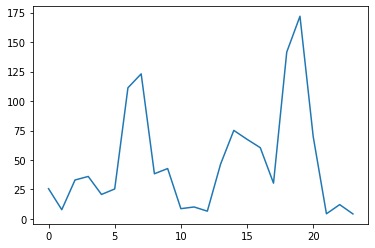

In [8]:
plt.plot(P_values)
plt.show()

Nous pouvons décorer notre graph avec des codes extra. Par exemple, exécuter ci-dessous et voir le graph de sortie. Vous pouvez tenter de personnaliser le graph.

C:\Users\ntr002\Anaconda3\envs\waporocw\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


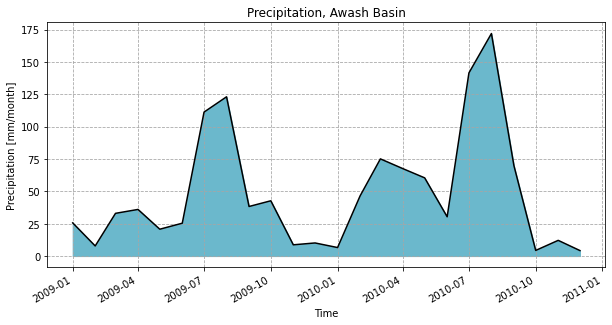

In [9]:
output_dir=r'.\data'
fig = plt.figure(figsize = (10,5))
plt.clf() #effacer le graph
plt.grid(b=True, which='Major', color='0.65',linestyle='--', zorder = 0) #Ajouter des lignes de grille
ax = plt.subplot(111)
ax.plot(dates, P_values, '-k') #tracer les données en ligne noire
ax.fill_between(dates, P_values, color = '#6bb8cc') #remplir la zone de ligne avec la couleur bleu
ax.set_xlabel('Time') #Ajouter un titre à l’axe X
ax.set_ylabel('Précipitation [mm/month]') #Ajouter un titre à  l’axe Y
ax.set_title('Précipitation, Awash Basin') #Ajouter un titre à la figure
fig.autofmt_xdate() #formatage automatique de l’axe des dates
plt.savefig(os.path.join(output_dir, 'Precipitation_Awash_ts.png')) #Enregistrer la figure dans output (sortie)
plt.show()

## 2. Travailler avec des séries chronologiques (librairie pandas)
### Exemple
Les liste créées (*dates*, *months*, *years*, *P_values*) peuvent être combinées dans un objet Trame de données (DataFrame) en utilisant *pandas.DataFrame*. Cette structure rend le nettoyage, la transformation, la manipulation et l’analyse plus simple.
Par exemple, le code ci-dessous créé une forme de trame de données à partir de la liste des date et valeurs de précipitation moyenne.

In [10]:
P_df=pd.DataFrame({'date':dates,'month':months,'year':years,'value': P_values})
P_df

,date,month,year,value
0,2009-01-01,1,2009,25.643679
1,2009-02-01,2,2009,7.820275
2,2009-03-01,3,2009,33.018497
3,2009-04-01,4,2009,36.029739
4,2009-05-01,5,2009,20.754398
5,2009-06-01,6,2009,25.401539
6,2009-07-01,7,2009,111.232544
7,2009-08-01,8,2009,123.038208
8,2009-09-01,9,2009,38.304550
9,2009-10-01,10,2009,42.717953


Par exemple, nous pouvons facilement additionner la précipitation des valeurs moyennes en précipitation annuelle totale en utilisant *groupby* de la colonne  *year* (année) avec la méthode *sum* (somme).

In [11]:
Year_total=P_df.groupby(['year']).sum()
Year_total['value']

year
2009    482.798503
2010    690.440463
Name: value, dtype: float64

Les colonnes de la trame de données (DataFrame) peuvent être convertie en matrice et facilement tracées. Ci-dessous se trouve le code pour tracer la précipitation totale annuelle.

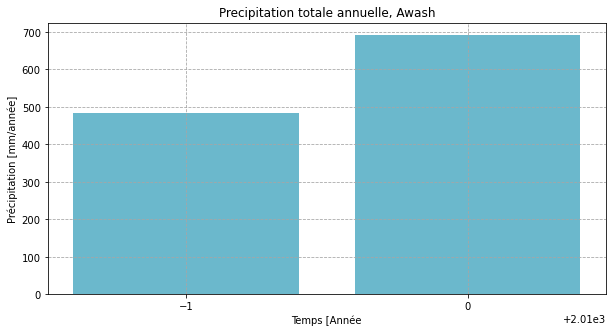

In [12]:
fig = plt.figure(figsize = (10,5))
ax2 = plt.subplot(111)
ax2.grid(b=True, which='Major', color='0.65',linestyle='--', zorder = 0) #Grid line
ax2.bar(Year_total.index, Year_total['value'].values, 0.8, color = '#6bb8cc')
ax2.set_xlabel('Temps [Année]')
ax2.set_xticks(Year_total.index)
ax2.set_ylabel('Précipitation [mm/année]')
ax2.set_title('Precipitation totale annuelle, Awash')
plt.savefig(os.path.join(output_dir, 'Precipitation_Awash_year.png'))
plt.show()
plt.close(fig)

Pour calculer et tracer la Précipitation moyenne du mois calendaire, on peut utiliser la méthode *groupby*, et se servir de *mean* (au lieu de sum) « moyenne au lieu de somme » : **P_df.groupby(['month']).mean()**

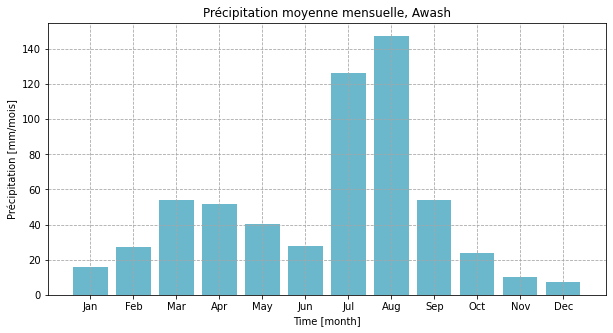

In [13]:
Month_avg=P_df.groupby(['month']).mean()
Month_avg['value']
fig = plt.figure(figsize = (10,5))
#subplot 1
ax1 = plt.subplot(111)
ax1.grid(b=True, which='Major', color='0.65',linestyle='--', zorder = 0) #Grid line
ax1.bar(Month_avg.index, Month_avg['value'].values, 0.8, color = '#6bb8cc')
ax1.set_xlabel('Time [month]')
monthname={1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
monthslabel=monthname.values()
ax1.set_xticks(Month_avg.index)
ax1.set_xticklabels(monthslabel)
ax1.set_ylabel('Précipitation [mm/mois]')
ax1.set_title('Précipitation moyenne mensuelle, Awash')
plt.savefig(os.path.join(output_dir, 'Precipitation_Awash_month.png'))
plt.show()
plt.close(fig)

Nous pouvons également enregistrer notre trame de données en tant fichier csv en utilisant la méthode *to_csv* de *pandas.DataFrame* pour un usage ultérieur dans d’autres analyses.

In [14]:
Month_max=P_df.groupby(['month']).max()
Month_min=P_df.groupby(['month']).min()
Month_med=P_df.groupby(['month']).median()
Month_std=P_df.groupby(['month']).std()

Month_stat=pd.DataFrame({'month': Month_avg.index,'Mean':Month_avg['value'].values,
                        'Max':Month_max['value'].values, 'Min':Month_min['value'].values,
                        'Median':Month_med['value'].values,'Std':Month_std['value'].values})
print(Month_stat)
Month_stat.to_csv(r'.\data\P_month_stats.csv',sep=';')

    month        Mean         Max         Min      Median        Std
0       1   16.115124   25.643679    6.586569   16.115124  13.475411
1       2   27.138358   46.456440    7.820275   27.138358  27.319894
2       3   54.050253   75.082008   33.018497   54.050253  29.743394
3       4   51.782978   67.536217   36.029739   51.782978  22.278444
4       5   40.590412   60.426426   20.754398   40.590412  28.052360
5       6   27.875678   30.349817   25.401539   27.875678   3.498961
6       7  126.365967  141.499390  111.232544  126.365967  21.401892
7       8  147.474548  171.910889  123.038208  147.474548  34.558204
8       9   54.071995   69.839439   38.304550   54.071995  22.298534
9      10   23.540389   42.717953    4.362825   23.540389  27.121171
10     11   10.420251   12.142183    8.698319   10.420251   2.435179
11     12    7.193530   10.138801    4.248259    7.193530   4.165242


## 3. Calcul de raster
### Exemple: P - ET
Premièrement, nous avons besoin du gestionnaire de fichiers des rasters de P et ET des mêmes dates qui ont été ajustés suivant la projection, la taille et la résolution. 

In [15]:
start_date='2009-01-01'
end_date='2010-12-31'
dates=pd.date_range(start_date,end_date,freq='M') #Créer une gamme de temps à partir de la date de début et de fin

P_path=r'.\data\WAPOR.v2_monthly_L1_PCP_M_clipped\L1_PCP_{:2}{:02d}M.tif' #canevas réel à formater
ET_path=r'.\data\WAPOR.v2_monthly_L1_AETI_M_clipped\L1_AETI_{:2}{:02d}M.tif' #canevas réel à formater

date=dates[0] #obtenir la première date de la gamme de temps
print(date)
P_fh=P_path.format(str(date.year)[2:],date.month) #formater le nom du fichier en utilisant la date
ET_fh=ET_path.format(str(date.year)[2:],date.month)# formater le nom du fichier en utilisant la date
print(P_fh)
print(ET_fh)

2009-01-31 00:00:00
.\data\WAPOR.v2_monthly_L1_PCP_M_clipped\L1_PCP_0901M.tif
.\data\WAPOR.v2_monthly_L1_AETI_M_clipped\L1_AETI_0901M.tif


La différence entre la Précipitation et l’Evapotranspiration totale (P-ET) du pixel peut indiquer si le pixel est un évier ou une source d’eau. Quand P-ET>0, de l’eau est générée dans la zone du pixel. Quand P-ET est inférieur à 0, l’eau est perdue dans la zone du pixel. Par exemple, ci-dessous est montré comment calculer P-ET pour un mois (Janvier 2009). Noter où P-ET est positif ou négatif.  

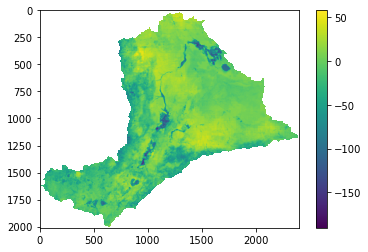

In [16]:
P=OpenAsArray(P_fh,nan_values=True)
ET=OpenAsArray(ET_fh,nan_values=True)
P_ET=P-ET
plt.imshow(P_ET)
plt.colorbar()
plt.show()

Nous pouvons utiliser un for-loop pour calculer des cartes de P-ET des mois de 2009. Les fichiers de sortie seront enregistrés dans le dossier [P-ET_M](data/P-ET_M)

In [17]:
output_folder=r'.\data\P-ET_M'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
for date in dates:
    print(date)
    P_fh=P_path.format(str(date.year)[2:],date.month) #formater le nom du fichier en utilisant la date sélectionnée
    ET_fh=ET_path.format(str(date.year)[2:],date.month) #formater le nom du  fichier en utilisant la date sélectionnée
    driver, NDV, xsize, ysize, GeoT, Projection=GetGeoInfo(P_fh)
    P=OpenAsArray(P_fh,nan_values=True)
    ET=OpenAsArray(ET_fh,nan_values=True)
    P_ET=P-ET
    filename='P-ET_{:2}{:02d}M.tif'.format(str(date.year)[2:],date.month)
    output_fh=os.path.join(output_folder,filename)
    print(output_fh)
    CreateGeoTiff(output_fh, P_ET, driver, NDV, xsize, ysize, GeoT, Projection)

2009-01-31 00:00:00
.\data\P-ET_M\P-ET_0901M.tif
2009-02-28 00:00:00
.\data\P-ET_M\P-ET_0902M.tif
2009-03-31 00:00:00
.\data\P-ET_M\P-ET_0903M.tif
2009-04-30 00:00:00
.\data\P-ET_M\P-ET_0904M.tif
2009-05-31 00:00:00
.\data\P-ET_M\P-ET_0905M.tif
2009-06-30 00:00:00
.\data\P-ET_M\P-ET_0906M.tif
2009-07-31 00:00:00
.\data\P-ET_M\P-ET_0907M.tif
2009-08-31 00:00:00
.\data\P-ET_M\P-ET_0908M.tif
2009-09-30 00:00:00
.\data\P-ET_M\P-ET_0909M.tif
2009-10-31 00:00:00
.\data\P-ET_M\P-ET_0910M.tif
2009-11-30 00:00:00
.\data\P-ET_M\P-ET_0911M.tif
2009-12-31 00:00:00
.\data\P-ET_M\P-ET_0912M.tif
2010-01-31 00:00:00
.\data\P-ET_M\P-ET_1001M.tif
2010-02-28 00:00:00
.\data\P-ET_M\P-ET_1002M.tif
2010-03-31 00:00:00
.\data\P-ET_M\P-ET_1003M.tif
2010-04-30 00:00:00
.\data\P-ET_M\P-ET_1004M.tif
2010-05-31 00:00:00
.\data\P-ET_M\P-ET_1005M.tif
2010-06-30 00:00:00
.\data\P-ET_M\P-ET_1006M.tif
2010-07-31 00:00:00
.\data\P-ET_M\P-ET_1007M.tif
2010-08-31 00:00:00
.\data\P-ET_M\P-ET_1008M.tif
2010-09-30 00:00:00


## Exercice  1
Suivre l’exemple de comment la moyenne de la précipitation mensuelle a été calculée dans les exemples, et calculer et tracer P-ET mensuels des années 2009 et 2010 dans le bassin de Awash.

In [18]:
'''Ecrivez votre code ici'''

'Ecrivez votre code ici'

## 4. Analyse de l’occupation des terres
### Exemple:
Nous allons premièrement découper les rasters d’occupation des terres LCC de WaPOR téléchargé dans [3 Télécharger en bloc des données de WaPOR](3_Bulk_download_WaPOR_data.ipynb) puis obtenir la liste des classes individuelles d’occupation des terres à partir des rasters de classification des couverts/occupations de WaPOR.

In [19]:
shp_fh=r".\data\Awash_shapefile.shp"
LCC_folder=r'.\data\WAPOR.v2_yearly_L1_LCC_A'
LCC_fhs=sorted(glob.glob(os.path.join(LCC_folder,'*.tif'))) #obtenir la liste de raster LCC (occupation des terres)
output_folder=r'.\data\WAPOR.v2_yearly_L1_LCC_A_clipped' # Nouveau dossier LCC
if not os.path.exists(output_folder):
    os.makedirs(output_folder) #Créer un nouveau dossier P
LCC_fhs=CliptoShp(LCC_fhs,output_folder,shp_fh) #découper tous les rasters LCC suivant le shapefile

Nous allons ouvrir une carte LCC en tant que matrice pour obtenir les valeurs unique dans la carte. Elles représentent les codes de classification de l’occupation des terres. Pour la description de ces codes, voir la métadonnées de la classification des l’occupation des terres dans le catalogue de WaPOR https://wapor.apps.fao.org/catalog/WAPOR_2/1/L1_LCC_A

| code        | Nom          | 
| :---------: |:-------------:| 
| 20 | Zone arbustive      | 
| 30      |  Prairie      | 
| 41      | Terre agricole (pluvial)    | 
| 42      | Terre agricole, irriguée sous gestion de l’eau  |
| 43      | Terre agricole, jachère |   
| 50 | Zone construites  |  
| 60 | Nu / végétation éparse  | 
| 80 | Retenue d’eau   | 
| 112 | Forestier : fermé, persistante. peuplement mixte | 
| 114 | Forestier : fermé , caduque.  peuplement mixte | 
| 116 | Forestier : fermé , type inconnu | 
| 124 | Forestier: ouvert, caduque  peuplement mixte | 
| 126 | Forestier: ouvert, type inconnu | 

In [20]:
LCC_fh=r".\data\WAPOR.v2_yearly_L1_LCC_A_clipped\L1_LCC_09.tif"
LCC=OpenAsArray(LCC_fh,nan_values=True)
LCC_values=np.unique(LCC[~np.isnan(LCC)])
LCC_codes=list(LCC_values)
print(LCC_codes)

[20.0, 30.0, 41.0, 42.0, 43.0, 50.0, 60.0, 80.0, 90.0, 112.0, 114.0, 116.0, 124.0, 126.0]


Pour calculer l’ET Moyenne de chaque occupation des terres, nous pouvons masquer la carte d’ET ou les valeurs de la carte LCC sont égales au code de chaque LCC, puis calculer **np.nanmean** de la matrice masquée. Par exemple, pour obtenir la valeur de l’ET des retenues d’eau (le code LCC est 80), on peut utiliser les étapes ci-dessous.   

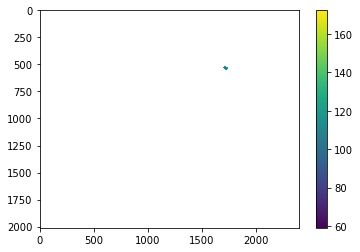

In [21]:
code=80 #Retenue d’eau

mask=np.where(LCC==code,0,1)
in_fh=r".\data\WAPOR.v2_monthly_L1_AETI_M_clipped\L1_AETI_0901M.tif"
var=OpenAsArray(in_fh,nan_values=True)

import numpy.ma as ma #importer le module maskarray (masquer données d’une matrice)
masked_map=ma.masked_array(var,mask)
plt.imshow(masked_map)
plt.colorbar()
plt.show()

Après cela, on peut calculer l’ET moyenne de la classe des retenues d’eau en utilisant la matrice masquée.   

In [22]:
average=np.nanmean(masked_map)
print('La moyenne de la classe d’occupation {0}: {1}'.format(code,average))

La moyenne de la classe d’occupation 80: 104.69696044921875


Nous pouvons maintenant utiliser for-loop sur les codes uniques de LCC pour calculer l’ET moyenne de chaque code d’occupation de terres (LCC). 

In [23]:
averages=[]
for code in LCC_codes:
    mask=np.where(LCC==code,0,1)
    masked_map=ma.masked_array(var,mask)
    averages.append(np.nanmean(masked_map))
LCC_avg=pd.DataFrame({'LCC code':LCC_codes,'Moyenne ': averages})
LCC_avg

,LCC code,Moyenne
0,20.0,37.537735
1,30.0,17.037479
2,41.0,47.709606
3,42.0,78.880722
4,43.0,6.646875
5,50.0,25.989452
6,60.0,8.477416
7,80.0,104.696960
8,90.0,100.415855
9,112.0,118.877800


## Exercice 2:

Calculer le tableau des moyennes annuelles de P-ET de toutes les occupations de terres du bassin de Awash pour l’année 2009.

**Indice**: La première étape consiste à additionner tous les rasters mensuels de P-ET de l’année 2009 pour calculer P-ET de cette année.

2009-01-31 00:00:00
2009-02-28 00:00:00
2009-03-31 00:00:00
2009-04-30 00:00:00
2009-05-31 00:00:00
2009-06-30 00:00:00
2009-07-31 00:00:00
2009-08-31 00:00:00
2009-09-30 00:00:00
2009-10-31 00:00:00
2009-11-30 00:00:00
2009-12-31 00:00:00


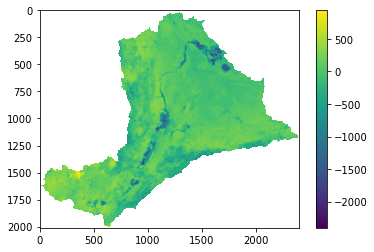

In [24]:
start_date='2009-01-01'
end_date='2009-12-31'
dates=pd.date_range(start_date,end_date,freq='M') #Créer une gamme de temps à partir de la date de début et de fin
PmET_path=r'.\data\P-ET_M\P-ET_{:2}{:02d}M.tif'
sameple_file=PmET_path.format(str(dates[0].year)[2:],dates[0].month)
driver, NDV, xsize, ysize, GeoT, Projection=GetGeoInfo(sameple_file)
SumArray=np.zeros((ysize,xsize))
for date in dates:
    print(date)
    PmET_fh=PmET_path.format(str(date.year)[2:],date.month) #Formater le nom du fichier en utilisant la date sélectionnée
    SumArray+=OpenAsArray(PmET_fh,nan_values=True)
output_fh=os.path.join('.\data\P-ET_2009.tif')
CreateGeoTiff(output_fh, P_ET, driver, NDV, xsize, ysize, GeoT, Projection)
plt.imshow(SumArray)
plt.colorbar()
plt.show()

Puis en utiliser les étapes qui ont été suivies dans le calcul de la moyenne d’ET de chaque classe d’occupation des terres pour calculer P-ET par classe d’occupation des terres.

Comparer l’Evaporation dans les principales classes : Forêt, zone arbustive, Prairie, retenues d’eau, sol nu, terre cultivée en pluvial, et culture irriguée. 

In [25]:
'''Ecrivez votre code ici'''

'Ecrivez votre code ici'